In [7]:
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
from sklearn.model_selection import GridSearchCV
import cv2
import seaborn as sns
import time
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Create necessary folders
folder_path = "D:\\csv file"
os.makedirs(folder_path, exist_ok=True)

# Define paths
confusion_image_path = os.path.join(folder_path, 'confusion_matrix.png')
classification_file_path = os.path.join(folder_path, 'classification_report.txt')
model_file_path = os.path.join(folder_path, "svm_model.pkl")

# Path to dataset
dataset_dir = "D:\\new dataset"
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test1")


In [9]:
# Load data, preprocess, and label
# dog = 1, cat = 0
train_images = os.listdir(train_dir)
features = []
labels = []
image_size = (50, 50)

# Process train images
for image in tqdm(train_images, desc="Processing Train Images"):
    if image.startswith('cat'):
        label = 0
    else:
        label = 1
    image_path = os.path.join(train_dir, image)
    image_read = cv2.imread(image_path)
    if image_read is not None:
        image_resized = cv2.resize(image_read, image_size)
        image_normalized = image_resized / 255.0
        image_flatten = image_normalized.flatten()
        features.append(image_flatten)
        labels.append(label)

# Convert lists to numpy arrays
features = np.asarray(features)
labels = np.asarray(labels)


Processing Train Images: 100%|█████████████████████████████████████████████████████| 2000/2000 [00:32<00:00, 62.26it/s]


In [10]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True, random_state=42)

# PCA, SVM, and Pipeline
n_components = 0.8
pca = PCA(n_components=n_components, random_state=42)
svm = SVC()
pipeline = Pipeline([
    ('pca', pca),
    ('svm', svm)
])

param_grid = {
    'pca__n_components': [2, 1, 0.9, 0.8],
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
}


In [11]:
# Calculate training time
start_time = time.time()
grid_search = GridSearchCV(pipeline, param_grid, cv=3, verbose=4)
grid_search.fit(X_train, y_train)
end_time = time.time()

# Obtain the best model and the best parameters
best_pipeline = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters: ", best_params)
print("Best Score: ", best_score)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END pca__n_components=2, svm__kernel=linear;, score=0.507 total time=   1.1s
[CV 2/3] END pca__n_components=2, svm__kernel=linear;, score=0.525 total time=   0.9s
[CV 3/3] END pca__n_components=2, svm__kernel=linear;, score=0.522 total time=   1.0s
[CV 1/3] END pca__n_components=2, svm__kernel=rbf;, score=0.560 total time=   0.8s
[CV 2/3] END pca__n_components=2, svm__kernel=rbf;, score=0.540 total time=   0.9s
[CV 3/3] END pca__n_components=2, svm__kernel=rbf;, score=0.576 total time=   1.0s
[CV 1/3] END pca__n_components=2, svm__kernel=poly;, score=0.496 total time=   0.6s
[CV 2/3] END pca__n_components=2, svm__kernel=poly;, score=0.535 total time=   0.6s
[CV 3/3] END pca__n_components=2, svm__kernel=poly;, score=0.495 total time=   0.6s
[CV 1/3] END pca__n_components=2, svm__kernel=sigmoid;, score=0.513 total time=   0.5s
[CV 2/3] END pca__n_components=2, svm__kernel=sigmoid;, score=0.486 total time=   0.5s
[CV 3/

Accuracy: 0.61
Classification Report:
               precision    recall  f1-score   support

         Cat       0.61      0.60      0.61       199
         Dog       0.61      0.62      0.61       201

    accuracy                           0.61       400
   macro avg       0.61      0.61      0.61       400
weighted avg       0.61      0.61      0.61       400



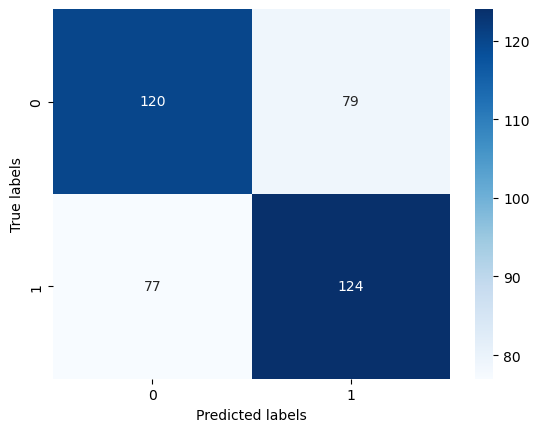

In [13]:
# Evaluation on test dataset
accuracy = best_pipeline.score(X_test, y_test)
print("Accuracy:", accuracy)
y_pred = best_pipeline.predict(X_test)

# Classification report
target_names = ['Cat', 'Dog']
classification_rep = classification_report(y_test, y_pred, target_names=target_names)
print("Classification Report:\n", classification_rep)

# Save the classification report
with open(classification_file_path, 'w') as file:
    file.write(classification_rep)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig(confusion_image_path)
plt.show()
